In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import keras
from keras import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout

In [ ]:
LABELS = open('custom.names.txt').read().split('\n')
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
weightsPath = 'bangla-digit_2000.weights'
configPath = './LICT_YOLO/data_for_colab/yolov3-tiny-obj.cfg'

print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [ ]:
image = cv2.imread('2.jpg')
(H, W) = image.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
    swapRB=True, crop=False)
net.setInput(blob)
layerOutputs = net.forward(ln)

boxes = []
confidences = []
classIDs = []

In [ ]:
for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.1:
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
 
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)

In [ ]:
boxes

[[21, 1, 62, 13],
 [265, 90, 155, 86],
 [542, 94, 149, 72],
 [1315, 78, 166, 112],
 [39, 101, 105, 89],
 [802, 97, 152, 100],
 [1029, 101, 155, 104]]

In [ ]:
boxes = np.array(boxes)

In [ ]:
len(boxes)

7

In [ ]:
boxes = boxes[boxes[:, 0].argsort()]

In [ ]:
boxes.shape

(7, 4)

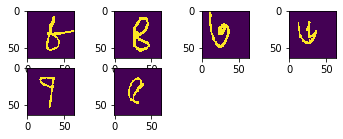

In [ ]:
temp = []
for i in range(1, len(boxes)):
    (x,y,w,h) = boxes[i]
    resized_images = cv2.resize(image[y:y+h, x:x+w], (64,64))
    gray_images = resized_images[:,:,0]
    ret, b_img = cv2.threshold(gray_images,128,255,cv2. THRESH_BINARY_INV)  
    temp.append(b_img)
    plt.subplot(4,4,i)
    plt.imshow(b_img)
    
b_img = np.array(temp)  

In [ ]:
b_img.shape

(6, 64, 64)

In [ ]:
b_img = b_img.reshape(-1,64,64,1)
b_img.shape

(6, 64, 64, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(64, 64, 1), activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
 
model.load_weights('digit-classifier.h5')

In [ ]:
#y_pred = model.predict(b_img)
#y_pred

In [ ]:
#for i in range(len(y_pred)):
    #print(np.argmax(y_pred[i]))

Text(0.5, 1.0, '843675')

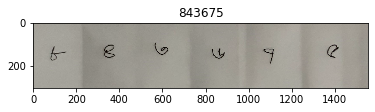

In [ ]:
s = ""
for i in range(len(temp)):
    y_pred = model.predict(b_img)
    title = np.argmax(y_pred[i])
    s = s+(str(title))

plt.imshow(image)
plt.title(s)